<a href="https://colab.research.google.com/github/noambassat/Macabi_Home_Assignment/blob/main/macabi_home_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [794]:
pip install ydata-profiling --quiet

In [795]:
pip install sweetviz --quiet

In [796]:
!wget -O Alef-Regular.ttf https://github.com/google/fonts/raw/main/ofl/alef/Alef-Regular.ttf --quiet

!pip install python-bidi arabic-reshaper --quiet



In [842]:
# IMPORTS
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from ydata_profiling import ProfileReport
from scipy import stats
from scipy.stats import ttest_ind,pointbiserialr
from bidi.algorithm import get_display
from wordcloud import WordCloud
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import warnings
from sklearn.metrics import precision_recall_curve

warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('ds_assignment_data.csv')
df.head()

In [ ]:
df.info()

In [ ]:
for col in df.columns: print(col)

In [ ]:
df["Y"].value_counts()

In [ ]:
df.dtypes.value_counts()

In [ ]:

all_columns = df.columns.tolist()

group1 = []  # match_* columns
group2 = []  # *_sum columns
group3 = []  # everything else

for col in all_columns:
    if(col=="Y"):
      group1.append(col)
      continue
    if col.startswith("match_"):
        group1.append(col)
    elif col.endswith("_sum"):
        group2.append(col)
    else:
        group3.append(col)

# Group 3: divide by prefix
prefix_groups = defaultdict(list)
for col in group3:
    prefix = col.split("_")[0]
    prefix_groups[prefix].append(col)


print("== Group 1: Y and match_* columns ==")
for col in group1:
    print(f"  - {col}")

print("\n== Group 2: *_sum columns ==")
for col in group2:
    print(f"  - {col}")

print("\n== Group 3: All other columns grouped by prefix ==")

group_3_dict = {}
for prefix, cols in prefix_groups.items():
    print(f"{prefix} ({len(cols)}):")
    group_3_dict[prefix] = cols
    for col in cols:
        print(f"  - {col}")
    print()


In [ ]:
df[group3].duplicated().sum()

In [ ]:
def initial_analysis(df: pd.DataFrame, group: list):

    display(df[group].info())

    drop_cols = []
    for col in group:
        print(f"\n=== {col} ===")
        vc = df[col].value_counts(dropna=False)
        display(vc)

        # Drop if only one unique value (constant)
        if df[col].nunique(dropna=False) == 1:
            drop_cols.append(col)

        # If continuous (numeric with many unique values), show stats
        elif pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique(dropna=False) > 10:
            print("\n[describe()]")
            display(df[col].describe())

    updated_group = [col for col in group if col not in drop_cols]

    return updated_group, drop_cols


## Group 1 - Target & Source Flags

In [ ]:
group1, drop_cols = initial_analysis(df, group1)

In [ ]:
df.drop(columns=drop_cols,inplace=True)

In [ ]:
group1_counts = pd.DataFrame(df[group1].value_counts().sort_values(ascending=False))
group1_counts

In [ ]:
print(drop_cols)

In [ ]:
# How many Y=1 have each match flag
df[df["Y"] == 1][group1].sum().sort_values()

In [ ]:
match_counts = df.loc[df["Y"] == 1, group1[:-1]].sum(axis=1)
match_counts.value_counts().sort_index()

In [ ]:
group1

In [ ]:
# Check for Y=1 rows with no match flags
df["no_match"] = (df[group1].sum(axis=1) == 0)
df[df["Y"] == 1]["no_match"].sum()

In [ ]:
# Check for Y=0 rows with match flags
df[(df["Y"] == 0) & (df[group1[:-1]].sum(axis=1) > 0)]

Summary of Target & Source Flags (Group 1):

- Y = 1 in 432 patients.
- All patients with Y=1 have at least one match_* flag > 0, indicating consistent labeling with diagnosis sources.
- match_measure_after is always 0 and was removed from the dataset.
- There are no missing values in any of the Group 1 columns.
- Among Y=1 cases:
  - 346 patients have exactly one match_* source.
  - 72 have two match sources.
  - 14 have three match sources.
- No patients with Y=0 have any match_* flags set to 1, confirming that match flags only appear in positively labeled cases.


## Group 2 - Diagnostic Subtype Counts

In [ ]:
group2, drop_cols2 = initial_analysis(df, group2)

בהוראות המשימה נאמר:

•	Cohort: Low- and moderate-risk pregnancies only. High-risk patients (known prior hypertensive disorders) are already automatically referred for testing and excluded from this dataset.
•	Prediction point: Week 15 of gestation. All features are aggregated backwards from that date.


כנראה בגלל זה העמודות הרלוונטיות ריקות, נסיר אותן

In [ ]:
df.drop(columns=drop_cols2,inplace=True)

In [ ]:
# Count unique combinations of the group2 columns
value_counts_df = df[group2].value_counts().reset_index(name='count')

value_counts_df.sort_values(by='count', ascending=False).sort_values(by='eclampsia_sum', ascending=False)

In [ ]:
group_2_corr = df[["essential_hypertension_sum", "pregnancy_hypertension_sum", "preeclampsia_sum", "eclampsia_sum", "labs_sum"]].corr().abs()
sns.heatmap(group_2_corr, annot=True)


1. טבלת צירופים (count)
רוב הנשים (9713 מתוך 10,000) לא קיבלו שום אבחנה (כל המשתנים בקבוצה 2 = 0).

המקרים הנפוצים ביותר בקרב Y=1 הם:

רק preeclampsia_sum = 1 (65 נשים)

רק pregnancy_hypertension_sum = 1 (53 נשים)

רק essential_hypertension_sum = 1 (45 נשים)

יש מיעוט קטן מאוד עם כמה אבחנות יחד (3 אבחנות ומעלה – רק בודדות).

labs_sum מופיע לבד ב־35 נשים – מעיד על ניטור, לא על חומרה גבוהה.

2. קורלציות
הקורלציות נמוכות עד בינוניות בין המשתנים

In [ ]:
df[(df["pregnancy_hypertension_sum"]==1) & (df["essential_hypertension_sum"]==1)].shape[0] # how many womam are both ?

In [ ]:
df[(df["Y"] == 0) & (df[group2].sum(axis=1) > 0)]

In [ ]:
group2

In [ ]:

def create_severity_features(df):
    severity_conditions = [
        ('eclampsia_sum', 8),
        ('preeclampsia_sum', 7),
        ('labs_sum', 6),
        ('essential_hypertension_sum', 5),
        ('pregnancy_hypertension_sum', 4),
        ('match_rasham_after', 3),
        ('match_pdf_after', 2),
        ('match_aspirin_after', 1),
    ]

    df['severity_score'] = 0
    for col, score in severity_conditions:
        df.loc[df[col] == 1, 'severity_score'] = np.maximum(df.loc[df[col] == 1, 'severity_score'], score)

    diagnosis_cols = [
        'eclampsia_sum',
        'preeclampsia_sum',
        'labs_sum',
        'essential_hypertension_sum',
        'pregnancy_hypertension_sum'
    ]

    df['diagnosis_count'] = df[diagnosis_cols].sum(axis=1)

    return df


df = create_severity_features(df)


In [ ]:
indicator_cols = group1 + group2
indicator_cols.remove('Y')
indicator_cols.remove('match_diag_141')
indicator_cols

## Group3 - Features by Group

In [ ]:
group_3_dict.keys()

### Drop constant

In [ ]:
def get_strict_constant_columns(df, columns):
    """
    Return columns where all values are exactly the same (excluding NaNs).
    NaNs break constancy.
    """
    return [col for col in columns if df[col].nunique(dropna=False) == 1 and (df[col].isna().sum() == 0 or df[col].isna().sum() == len(df))]


In [ ]:
print(get_strict_constant_columns(df,group3))

In [ ]:
to_remove = ["lab_num_of_fetuses_last_value", "4_diag_88_days_since_last_diag"]

# Drop from DataFrame
df.drop(columns=to_remove, inplace=True)

# Drop from group dicts
group_3_dict["lab"] = [col for col in group_3_dict["lab"] if col not in to_remove]
group_3_dict["4"] = [col for col in group_3_dict["4"] if col not in to_remove]

# Drop from group3
group3 = [col for col in group3 if col not in to_remove]


In [ ]:
def plot_filtered_correlation_heatmap(df, columns=group3, threshold=0.8, method='pearson'):
    """
    Plots a full heatmap of correlations for features that have at least one strong correlation
    (excluding self-correlation). Keeps only features with at least 2 correlations ≥ threshold
    including the diagonal (self-correlation).

    Parameters:
    - df: DataFrame with data
    - columns: list of columns to include (numeric only)
    - threshold: minimum absolute correlation to include (e.g. 0.8)
    - method: 'pearson', 'spearman', or 'kendall'
    """
    # Select numeric subset
    if columns is None:
        df_corr = df.select_dtypes(include=['float64', 'int64'])
    else:
        df_corr = df[columns].select_dtypes(include=['float64', 'int64'])

    # Compute correlation matrix
    corr = df_corr.corr(method=method)

    # Count number of strong correlations (|r| ≥ threshold), including self (diagonal = 1.0)
    abs_corr = corr.abs()
    strong_counts = (abs_corr >= threshold).sum(axis=1)

    # Keep only features with at least 2 strong correlations (self + at least one other)
    keep_features = strong_counts[strong_counts >= 2].index
    corr_filtered = corr.loc[keep_features, keep_features]

    if corr_filtered.empty:
        print(f"No features with ≥1 strong correlation (|r| ≥ {threshold}).")
        return

    # Plot full heatmap (no mask)
    plt.figure(figsize=(max(10, 0.5 * len(corr_filtered)), max(6, 0.5 * len(corr_filtered))))
    sns.heatmap(corr_filtered, annot=True, cmap='coolwarm',
                vmin=-1, vmax=1, linewidths=0.5, fmt=".2f")
    plt.title(f'Correlation Heatmap | ≥1 strong correlation (|r| ≥ {threshold})')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_feature_distribution(df, columns, lower=0.01, upper=0.99):
    for col in columns:
        # percentile bounds
        lower_bound = df[col].quantile(lower)
        upper_bound = df[col].quantile(upper)

        # histogram
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df, x=col)
        plt.title(col)
        plt.tight_layout()
        plt.show()

        # boxplot with percentile lines
        plt.figure(figsize=(6, 3))
        sns.boxplot(data=df, x=col)
        plt.axvline(lower_bound, color='red', linestyle='--')
        plt.axvline(upper_bound, color='red', linestyle='--')
        plt.title(col)
        plt.tight_layout()
        plt.show()


In [ ]:
def plot_feature_by_group(df, x_col, y_col, title=None):
    """
    Plots a boxplot using the given DataFrame, X and Y column names.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        x_col (str): The column name for the X-axis (categorical).
        y_col (str): The column name for the Y-axis (numeric).
        title (str, optional): Title of the plot. Defaults to auto-generated.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=x_col, y=y_col, data=df)

    if title is None:
        title = f'{y_col} Distribution by {x_col}'

    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()




    plt.figure(figsize=(6,4))
    sns.barplot(x=x_col, y=y_col, data=df)
    plt.title(f'{y_col} by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(f'{y_col}')
    plt.show()

In [ ]:
group_3_dict.keys()

### Handle features by types (prefix)

#### init_date

In [ ]:
df[group_3_dict["int"]].info()

In [ ]:
df[group_3_dict["int"]].describe()

In [ ]:
# Attempt to interpret int_date as datetime
df['int_date_dt'] = pd.to_datetime(df['int_date'], origin='1899-12-30', unit='D')
df['int_date_dt'].describe()

התוצאות מראות שהמשתנה כנראה לא מתאר תאריך אמיתי\לא חליץ

In [ ]:
# Based on the range of years (e.g. 1900 to 2147), this column does not represent a valid date.
# We drop both the original and derived columns.
df.drop(columns=['int_date', 'int_date_dt'], inplace=True)

In [ ]:
group_3_dict['int'].remove('int_date')
group3.remove('int_date')

#### Demog

In [ ]:
df[group_3_dict['demog']].info()

In [ ]:
df[group_3_dict['demog']].describe()

In [ ]:
df.groupby('Y')['demog_customer_age'].describe()

In [ ]:
plot_feature_by_group(df, 'Y', 'demog_customer_age')

In [ ]:
plot_feature_distribution(df, ['demog_customer_age'])

In [ ]:
df['demog_capitationcoefficient'].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
df["demog_capitationcoefficient"].unique()

In [ ]:
print("Distribution of Y by whether 'demog_customer_age' is missing:")
df.groupby(df['demog_customer_age'].isna())['Y'].value_counts(normalize=True)

In [ ]:
print("Summary statistics for 'demog_capitationcoefficient' grouped by missingness of 'demog_customer_age':")
(df.groupby(df['demog_customer_age'].isna())['demog_capitationcoefficient'].describe())

In [ ]:
df[df['demog_customer_age'].isna() & df['demog_capitationcoefficient'].isna()].shape

In [ ]:
df[df['demog_customer_age'].isna()].index == df[df['demog_capitationcoefficient'].isna()].index

In [ ]:
df[df['demog_customer_age'].isna()]['Y'].value_counts()

##### Handle missing demog

In [ ]:
df.dropna(subset=['demog_customer_age', 'demog_capitationcoefficient'],inplace=True)

החלטתי להסיר את השורות עם חוסר בגיל ובמקדם הקפיטציה מאחר שחסרים בהן כל המשתנים הדמוגרפיים המרכזיים, אין בהן אבחנות (Y=1), ומספרן זניח כך שהשפעת הסרתן על המודל אינה משמעותית.


#### Smoking

#####  Smoking Analysis

In [ ]:
smoking_cols = group_3_dict["smoking"]

In [ ]:
df[smoking_cols].info()

In [ ]:
df[smoking_cols].describe()

In [ ]:
df['smoking_is_smoker'].value_counts(dropna=False)

In [ ]:
df['smoking_is_smoker'] = df['smoking_is_smoker'].astype('category')

In [ ]:
df.groupby(df['smoking_is_smoker'].isna())['Y'].value_counts(normalize=True)

In [ ]:
df.groupby(df['smoking_is_smoker'].isna())['demog_customer_age'].describe()



In [ ]:
df.groupby(df['smoking_is_smoker'].isna())['demog_capitationcoefficient'].describe()

מסקנה:

החוסר ב־smoking_is_smoker כנראה לא רנדומלי לחלוטין (לא MCAR טהור) —

אבל ההשפעה על Y מאוד מתונה

החוסרים ב־smoking_is_smoker כנראה MAR מתון

In [ ]:
# האם כדאי להוסיף משתנה אינדיקטור לחוסר במשתנה העישון ?
# df['is_smoker_missing'] = df['smoking_is_smoker'].isna().astype(int)


In [ ]:
plot_feature_by_group(df, 'smoking_is_smoker', 'Y')

In [ ]:
df[df['smoking_smoking_years'] > 40][['smoking_smoking_years']].shape[0]

140 נשים הריניות שמעשנות מעל 40 שנה ? לא הגיוני וזה ערך חריג\טעות

In [ ]:
df.groupby('smoking_is_smoker')['smoking_smoking_years'].describe()

In [ ]:
df['smoking_total_heavy_smokers'].value_counts().sort_index()

In [ ]:
df.groupby('smoking_is_smoker')['smoking_total_heavy_smokers'].mean()

In [ ]:
df.groupby(df['smoking_total_heavy_smokers'] > 0)['Y'].mean()

In [ ]:
df[(df['smoking_is_smoker'] != 0) & (df['smoking_smoking_years'] == 0)][smoking_cols].shape

מה המשמעות?
מדובר על 257 נשים שמדווחות כמעשנות בעבר או בהווה, אבל לכאורה עישנו אפס שנים.

מתוך 257:

רובן עם smoking_is_smoker == 2.0 → כנראה דיווח לקוי של מעשנות בעבר שלא מסרו משך עישון.

מעטות עם smoking_is_smoker == 1.0 → זו כבר סתירה חמורה יותר.

In [ ]:
df[(df['smoking_is_smoker'].isna()) & (~df['smoking_smoking_years'].isna())][smoking_cols]

In [ ]:
df[(df['smoking_is_smoker'] == 0) & (df['smoking_smoking_years'] != 0)][smoking_cols]

In [ ]:
plot_feature_by_group(df, 'smoking_is_smoker', 'smoking_smoking_years')

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['smoking_smoking_years'], bins=30, kde=True)
plt.title('Histogram of Smoking Years')
plt.xlabel('Smoking Years')
plt.ylabel('Count')
plt.show()

##### Handle Smoking Annomals


אפשר לנסות לחלץ משמעותיות עישון מהטקסט החופשי של הרופא, אבל כיוון שהקורלציה בין המשתנים האלה למשתנה המטרה כשלעצמה מאוד נמוכה, אטפל בזה כרגע בצורה נאיבית.

מעל 40 שנות עישון זה לא הגיוני לנשים בהריון, הן מקסימום בנות 45, ולא מעשנות מגיל 5, ככה שגם 40 זה טווח מוגדל

In [ ]:
(df['smoking_smoking_years'].isna() & (df['smoking_is_smoker'].notna())).sum()

In [ ]:
df.loc[df['smoking_smoking_years'] > 50, 'smoking_smoking_years'] = np.nan

In [ ]:
df.loc[(df['smoking_is_smoker'].isin([1, 2])) & (df['smoking_smoking_years'] == 0), 'smoking_smoking_years'] = np.nan

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['smoking_smoking_years'].dropna(), bins=30, kde=True)
plt.title('Histogram of Smoking Years')
plt.xlabel('Smoking Years')
plt.ylabel('Count')
plt.show()

In [ ]:
plot_feature_by_group(df, 'smoking_is_smoker', 'smoking_smoking_years')

In [ ]:
(df['smoking_smoking_years'].isna() & (df['smoking_is_smoker'].notna())).sum()

In [ ]:
mask = df['smoking_smoking_years'].isna() & df['smoking_is_smoker'].notna()
df.loc[mask, 'Y'].value_counts(normalize=True)

In [ ]:
df.loc[mask, ['demog_customer_age', 'demog_capitationcoefficient']].describe()

In [ ]:
# pd.set_option('display.max_rows', None)

##### Smoking summary

לא יצרתי פיצ'ר שמציין חוסרים כי אני לא עושה אימפיוטציה, והמודל ידע להתמודד עם NaN בעצמו.

397 שורות שהפכו ל־NaN ב־smoking_smoking_years שומרות מידע חשוב (גיל, קפיטציה), ולכן לא הוסרו.

החוסרים ב־smoking_is_smoker כנראה MAR, ללא השפעה מהותית על Y – נשארו בדאטה.









#### Lab

In [ ]:
df[group_3_dict['lab']].info()

In [ ]:
df[group_3_dict['lab']].describe().T

In [ ]:
plot_feature_distribution(df, group_3_dict['lab'])

In [ ]:
plot_filtered_correlation_heatmap(df,group_3_dict['lab'], threshold=0.8, method='pearson')

#### measure

In [ ]:
df[group_3_dict['measure']].info()

In [ ]:
df[group_3_dict['measure']].describe().T

In [ ]:
plot_feature_distribution(df, group_3_dict['measure'])

In [ ]:
plot_filtered_correlation_heatmap(df, columns=group_3_dict['measure'], threshold=0.8, method='pearson')

#### 4 & 24

In [ ]:
group_4_24 = group_3_dict['4'] + group_3_dict['24']

In [ ]:
df[group_4_24].info()

In [ ]:
total_rows = df.shape[0]

non_missing = df[group_4_24].notna().sum()
coverage = (non_missing / total_rows * 100).round(2)

low_coverage = pd.DataFrame({
    'non_missing_count': non_missing,
    'coverage_percent': coverage
}).sort_values('non_missing_count')

low_coverage = low_coverage[low_coverage['non_missing_count'] < 100]

print(low_coverage)

In [ ]:
# Calculate Y==1 stats for each column in low_coverage
y_1_percent = {}
y_1_count = {}
y_0_count = {}

for col in low_coverage.index.tolist():
    valid_rows = df[col].notna()
    if valid_rows.sum() > 0:
        y_valid = df.loc[valid_rows, 'Y']
        y_1_count[col] = int((y_valid == 1).sum())
        y_0_count[col] = int((y_valid == 0).sum())
        y_1_percent[col] = round(y_valid.mean() * 100, 2)
    else:
        y_1_count[col] = 0
        y_0_count[col] = 0
        y_1_percent[col] = None

# Add new columns to the table
low_coverage['Y==1_count'] = pd.Series(y_1_count)
low_coverage['Y==0_count'] = pd.Series(y_0_count)
low_coverage['Y==1_percent'] = pd.Series(y_1_percent)

# Display updated table
display(low_coverage)


In [ ]:
low_coverage = low_coverage[low_coverage['non_missing_count'] < 10] # drop less than 10 not-null

In [ ]:
cols_to_drop = low_coverage.index.tolist()
cols_to_drop

In [ ]:
df.drop(columns=cols_to_drop, inplace=True)
group_4_24 = [col for col in group_4_24 if col not in cols_to_drop]
group3 = [col for col in group3 if col not in cols_to_drop]

In [ ]:
# Create two feature groups based on column suffix
num_of_diag_cols = [col for col in group_4_24 if col.endswith('_num_of_diag')]
days_since_diag_cols = [col for col in group_4_24 if col.endswith('_days_since_last_diag')]

#####num_of_diag_cols

In [ ]:
df[num_of_diag_cols].describe().T

In [ ]:
plot_feature_distribution(df, num_of_diag_cols)

In [ ]:
def plot_diag_distribution(df, group):
  for column in group:
    counts = df[column].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Number of diagnoses')
    plt.ylabel('Number of patients')
    plt.tight_layout()
    plt.show()


plot_diag_distribution(df,num_of_diag_cols)

In [ ]:
df[num_of_diag_cols] = df[num_of_diag_cols].astype(int)

total_diag_count = מספר האבחנות מכל הסוגים שהאישה קיבלה ב־4 ו־24 החודשים האחרונים.

נבנה על בסיס סך כל העמודות שמסתיימות ב־_num_of_diag.



In [ ]:
df['total_diag_count'] = df[num_of_diag_cols].sum(axis=1)

In [ ]:
sns.barplot(x='Y', y='total_diag_count', data=df)
plt.title("Total Diagnosis Count by Y")


In [ ]:
df.groupby('Y')['total_diag_count'].agg(['mean', 'std', 'median', 'max'])

נשים חולות (Y=1) מקבלות יותר אבחנות בממוצע.

ה־max של Y=1 גבוה מאוד — ייתכן שחולות יותר מורכבות רפואית

ה־std גבוה יותר אצל Y=1 → הפיצ'ר גם מבחין וגם משקף עומס קליני

In [ ]:

group_0 = df[df['Y'] == 0]['total_diag_count']
group_1 = df[df['Y'] == 1]['total_diag_count']
stat, p = ttest_ind(group_0, group_1, equal_var=False)
print(f"t-test p-value = {p:.4e}")


הממוצע של הפיצ'ר שונה בין הערכים של Y

ממוצע גבוה יותר אצל נשים חולות (Y=1).

##### days_since_diag_cols

In [ ]:
df[days_since_diag_cols].describe().T

In [ ]:
plot_feature_distribution(df, days_since_diag_cols)

In [ ]:
violations_4 = []
violations_24 = []

for col in df.columns:
    if col.startswith('4_diag_') and col.endswith('_days_since_last_diag'):
        mask = df[col] > 120
        if mask.any():
            violations_4.append((col, mask.sum()))
    elif col.startswith('24_diag_') and col.endswith('_days_since_last_diag'):
        mask = df[col] > 730
        if mask.any():
            violations_24.append((col, mask.sum()))

print("\nViolations of rule for 4_diag (>120 days):")
for v in violations_4:
    print(f"{v[0]}: {v[1]} rows")

print("\nViolations of rule for 24_diag (>730 days):")
for v in violations_24:
    print(f"{v[0]}: {v[1]} rows")


In [ ]:
df.loc[df['4_diag_94_days_since_last_diag'] > 120, ['4_diag_94_days_since_last_diag','Y']]

In [ ]:
df.loc[df['24_diag_61_days_since_last_diag'] > 730, ['24_diag_61_days_since_last_diag','Y']]

In [ ]:

df_melted = df[days_since_diag_cols + ['Y']].melt(id_vars='Y')

plt.figure(figsize=(12, max(6, len(days_since_diag_cols) * 0.3)))
sns.boxplot(x='value', y='variable', hue='Y', data=df_melted, orient='h', showfliers=False)
plt.title('Distribution of Days Since Last Diagnosis (by Y)')
plt.tight_layout()
plt.show()


In [ ]:
plot_filtered_correlation_heatmap(df, columns=days_since_diag_cols, threshold=0.8, method='pearson')

In [ ]:
group3.remove('clinical_sheet')

In [ ]:
group3

### EDA

In [ ]:
def add_severity_and_source(df):
    # Severity clearly defined medically
    severity_conditions = [
        ('eclampsia_sum', 'Eclampsia'),
        ('preeclampsia_sum', 'Preeclampsia'),
        ('labs_sum', 'Lab-based diagnosis'),
        ('essential_hypertension_sum', 'Essential Hypertension'),
        ('pregnancy_hypertension_sum', 'Pregnancy Hypertension')
    ]

    df['severity_level'] = 'No Diagnosis'
    for col, level in severity_conditions:
        df.loc[(df[col] == 1) & (df['severity_level'] == 'No Diagnosis'), 'severity_level'] = level

    # Source of diagnosis clearly separated
    source_conditions = [
        ('match_pdf_after', 'Hospital Document (PDF)'),
        ('match_rasham_after', 'Medical Registry (Rasham)'),
        ('match_aspirin_after', 'Aspirin prescription'),
        ('match_diag_141', 'Diagnosis Registry')
    ]

    df['diagnosis_source'] = 'No Diagnosis'
    for col, source in source_conditions:
        df.loc[(df[col] == 1) & (df['diagnosis_source'] == 'No Diagnosis'), 'diagnosis_source'] = source

    return df



# severity_order = [
#         'Eclampsia',
#         'Preeclampsia',
#         'Lab-based diagnosis',
#         'Essential Hypertension',
#         'Pregnancy Hypertension',
#         'No Diagnosis'
# ]

df = add_severity_and_source(df)


In [ ]:
'match_rasham_after',
 'match_aspirin_after',
 'match_pdf_after',
 'essential_hypertension_sum',
 'pregnancy_hypertension_sum',
 'preeclampsia_sum',
 'eclampsia_sum',
 'labs_sum'

In [ ]:
# 1. Validate diagnosis_source matches Y perfectly
no_source_but_positive_Y = df[(df['diagnosis_source'] == 'No Diagnosis') & (df['Y'] != 0)]
source_but_negative_Y = df[(df['diagnosis_source'] != 'No Diagnosis') & (df['Y'] != 1)]

print(f"No source but Y=1 cases: {len(no_source_but_positive_Y)} (should be 0)")
print(f"Has source but Y=0 cases: {len(source_but_negative_Y)} (should be 0)")

# 2. Validate severity_level matches match_diag_141 and Y correctly
no_severity_but_diag141 = df[(df['severity_level'] == 'No Diagnosis') & (df['match_diag_141'] != 0)]
severity_but_no_diag141 = df[(df['severity_level'] != 'No Diagnosis') & (df['match_diag_141'] != 1)]
severity_but_negative_Y = df[(df['severity_level'] != 'No Diagnosis') & (df['Y'] != 1)]

print(f"No severity but match_diag_141=1 cases: {len(no_severity_but_diag141)} (should be 0)")
print(f"Has severity but match_diag_141=0 cases: {len(severity_but_no_diag141)} (should be 0)")
print(f"Has severity but Y=0 cases: {len(severity_but_negative_Y)} (should be 0)")


In [ ]:
def plot_distribution(df,y_col):
    plt.figure(figsize=(10,6))
    sns.countplot(
        y=y_col,
        data=df,
        order=df[y_col].value_counts().index,
        palette='viridis'
    )
    plt.title(f'Distribution of {y_col}', fontsize=16)
    plt.xlabel('Number of Patients')
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()


# plot pie chart
def plot_pie_chart(df, y_col, no_zeros = False):
  plt.figure(figsize=(8, 8))
  counts = counts = df[y_col].value_counts()
  plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
  title = f'{y_col} Distribution'
  if no_zeros:
    title += ' (non-zero cases)'
  plt.title(title)
  plt.tight_layout()
  plt.show()

In [ ]:
plot_pie_chart(df, 'Y')

#### Severity Level Distribution

In [ ]:
plot_distribution(df,'severity_level')

In [ ]:
# filter out rows with 'No Diagnosis'
severity_filtered = df[df['severity_level'] != 'No Diagnosis']


plot_distribution(severity_filtered, "severity_level")


In [ ]:
plot_pie_chart(severity_filtered, y_col='severity_level', no_zeros=True)

In [ ]:
df['diagnosis_source'].unique()

In [ ]:

# filter out rows with 'No Diagnosis'
diag_filtered = df[df['diagnosis_source'] != 'No Diagnosis']

plot_distribution(diag_filtered, y_col="diagnosis_source")


In [ ]:
plot_pie_chart(severity_filtered, y_col='severity_level', no_zeros=True)

#### Demogarphy distribution

In [ ]:
def plot_boxplot_distribution(target_col):
  for col in ['demog_customer_age', 'demog_capitationcoefficient']:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=target_col, y=col, data=df, palette='coolwarm')
    plt.title(f'{col} Distribution by {target_col}', fontsize=16)
    plt.xticks(rotation=45)
    plt.xlabel(target_col)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


##### Demogarphy distribution by Y (Boxplot)

In [ ]:
plot_boxplot_distribution('Y')

##### Demogarphy distribution by Severity Level (Boxplot)

In [ ]:
plot_boxplot_distribution('severity_level')

In [ ]:
plot_boxplot_distribution('diagnosis_source')

In [ ]:
def smoking_status_by_target(target_col):
  smoking_pivot = pd.crosstab(df[target_col], df['smoking_is_smoker'], normalize='index')
  # smoking_pivot = smoking_pivot.reindex(severity_order)

  smoking_pivot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
  plt.title(f'Smoking Status by {target_col}', fontsize=16)
  plt.xlabel(target_col)
  plt.ylabel('Percentage')
  plt.legend(title='Smoker Status', bbox_to_anchor=(1,1))
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
smoking_status_by_target('Y')

In [ ]:
smoking_status_by_target('severity_level')

In [ ]:
smoking_status_by_target('diagnosis_source')

In [ ]:
def Blood_Pressure_By_target(target_col):
  bp_means = df.groupby(target_col)[[
      'measure_blood_pressure_sys_mean_val',
      'measure_blood_pressure_dias_mean_val'
  ]].mean()

  plt.figure(figsize=(11,5))
  sns.heatmap(bp_means, annot=True, fmt=".1f", cmap='YlGnBu')

  plt.title(f'Mean Blood Pressure by {target_col}', fontsize=12)
  plt.xlabel('Blood Pressure Measure', fontsize=10)
  plt.ylabel(target_col, fontsize=10)

  plt.xticks(rotation=30, ha='right')

  plt.tight_layout()
  plt.show()

In [ ]:
Blood_Pressure_By_target('Y')

In [ ]:
Blood_Pressure_By_target('severity_level')

In [ ]:
Blood_Pressure_By_target('diagnosis_source')

fmt=".1f" מציג את המספרים כ־120.5 במקום 1.2e+02

In [ ]:
def labs_by_target(target_col, target_binary=0):
  lab_cols = [col for col in df.columns if col.startswith('lab_')]
  col_binary = (df[target_col] != target_binary).astype(int)

  correlations = {col: pointbiserialr(df[col].fillna(0), col_binary)[0] for col in lab_cols}
  top_labs = sorted(correlations, key=lambda x: abs(correlations[x]), reverse=True)[:5]

  for col in top_labs:
      plt.figure(figsize=(10, 6))
      sns.boxplot(x=target_col, y=col, data=df, palette='Spectral')
      plt.title(f'{col} by {target_col}', fontsize=16)
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()


In [ ]:
labs_by_target('Y')

In [ ]:

labs_by_target('severity_level', target_binary='No Diagnosis')

In [ ]:
df['diagnosis_source'].unique()

In [ ]:
labs_by_target('diagnosis_source', "No Diagnosis")

In [ ]:
lab_cols = [col for col in df.columns if col.startswith('lab_')]
severity_binary = (df['severity_level'] != 'No Diagnosis').astype(int)

correlations = {col: pointbiserialr(df[col].fillna(0), severity_binary)[0] for col in lab_cols}
top_labs = sorted(correlations, reverse=True)[:5]

for col in top_labs:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='severity_level', y=col, data=df, palette='Spectral')
    plt.title(f'{col} by Severity Level', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. התפלגות Severity Level
plt.figure(figsize=(10,6))
sns.countplot(y='severity_level', data=df, order=df['severity_level'].value_counts().index, palette='viridis')
plt.title('Distribution of Severity Levels', fontsize=16)
plt.xlabel('Number of Patients')
plt.ylabel('Severity Level')
plt.tight_layout()
plt.show()

# 2. התפלגות Diagnosis Source
plt.figure(figsize=(10,6))
sns.countplot(y='diagnosis_source', data=df, order=df['diagnosis_source'].value_counts().index, palette='mako')
plt.title('Distribution of Diagnosis Sources', fontsize=16)
plt.xlabel('Number of Patients')
plt.ylabel('Diagnosis Source')
plt.tight_layout()
plt.show()

# 3. התפלגות אבחנה כללית Y
plt.figure(figsize=(6,4))
sns.countplot(x='Y', data=df, palette='Set2')
plt.title('Distribution of General Diagnosis (Y)', fontsize=16)
plt.xlabel('General Diagnosis (Y)')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

# משתנים רציפים להשוואה (דוגמאות חשובות)
continuous_features = [
    'demog_customer_age',
    'measure_blood_pressure_sys_mean_val',
    'measure_blood_pressure_dias_mean_val'
]

# 4. השוואת משתנים רציפים לפי Severity Level
for col in continuous_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='severity_level', y=col, data=df, palette='coolwarm')
    plt.title(f'{col} by Severity Level', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 5. השוואת משתנים רציפים לפי Diagnosis Source
diagnosis_source_features = [
    'demog_customer_age',
    'measure_blood_pressure_sys_count'
]

for col in diagnosis_source_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='diagnosis_source', y=col, data=df, palette='pastel')
    plt.title(f'{col} by Diagnosis Source', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 6. השוואת משתנים רציפים לפי אבחנה כללית (Y)
for col in continuous_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Y', y=col, data=df, palette='Accent')
    plt.title(f'{col} by General Diagnosis (Y)', fontsize=16)
    plt.tight_layout()
    plt.show()

# 7. Smoking vs Severity Level
smoking_pivot = pd.crosstab(df['severity_level'], df['smoking_is_smoker'], normalize='index')
smoking_pivot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set3')
plt.title('Smoking Status by Severity Level', fontsize=16)
plt.xlabel('Severity Level')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Smoker Status', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# 8. Smoking vs Y
smoking_pivot_y = pd.crosstab(df['Y'], df['smoking_is_smoker'], normalize='index')
smoking_pivot_y.plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set3')
plt.title('Smoking Status by General Diagnosis (Y)', fontsize=16)
plt.xlabel('General Diagnosis (Y)')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Smoker Status', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# 9. Heatmap מקור אבחנה מול חומרה (Crosstab)
severity_source_crosstab = pd.crosstab(df['diagnosis_source'], df['severity_level'], normalize='index')

plt.figure(figsize=(10,7))
sns.heatmap(severity_source_crosstab, annot=True, cmap='coolwarm')
plt.title('Heatmap of Diagnosis Source vs Severity Level', fontsize=16)
plt.xlabel('Severity Level')
plt.ylabel('Diagnosis Source')
plt.tight_layout()
plt.show()


### NLP - Clinical Sheet

In [ ]:
df["clinical_sheet"].isna().sum()

In [ ]:
df['clinical_length'] = df['clinical_sheet'].str.len()
df.groupby(df[indicator_cols].sum(axis=1) > 0)['clinical_length'].mean()


In [ ]:
def print_cleaned_examples(df, label_value,clinical_col="clinical_sheet", n=3):
    examples = df[df['Y'] == label_value][clinical_col].dropna().sample(n, random_state=42)
    print(f"\n=== {n} Examples where Y = {label_value} ===\n")
    for i, text in enumerate(examples, start=1):
        print(f"--- Example {i} ---\n{text.strip()}\n")

print_cleaned_examples(df, label_value=1, n=3)
print_cleaned_examples(df, label_value=0, n=3)


##### TF-IDF

In [ ]:
# Compute TF-IDF
vectorizer = TfidfVectorizer(use_idf=True, min_df=5, sublinear_tf=True)
vec_sparse = vectorizer.fit_transform(df['clinical_sheet'])
vec_df = pd.DataFrame(vec_sparse.todense(), columns=vectorizer.get_feature_names_out())

vec_df.T

In [ ]:
chi2(vec_df[['כספית']], df['Y']==1)

# Right value is the p-value:
#  a very low p-value indicates that the word "כספית" ("Mercury") is significantly correlated with cases labeled as "sick" (Y=1),
#  distinguishing them clearly from non-sick cases.




In [ ]:
chi2(vec_df[["nulliparity"]],df["Y"]==1)

In [ ]:
chi2(vec_df[["דם"]],df["Y"]==1)

In [ ]:
# Reset the index of df
df_reset = df.reset_index(drop=True)

# Chi2 scores and p-values
chi2_scores, p_values = chi2(vec_df, df_reset['Y'])

# Create DataFrame with results
chi2_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'chi2_score': chi2_scores,
    'p_value': p_values,
})

chi2_df

In [ ]:

# Add average TF-IDF per class
chi2_df['tfidf_mean_Y1'] = vec_df[df_reset['Y'] == 1].mean(axis=0).values
chi2_df['tfidf_mean_Y0'] = vec_df[df_reset['Y'] == 0].mean(axis=0).values

# Clearly assign each word to the class with higher mean TF-IDF
chi2_df['class'] = np.where(chi2_df['tfidf_mean_Y1'] > chi2_df['tfidf_mean_Y0'], 1, 0)



In [ ]:
# Sort words by chi2_score for each class separately
top_words_Y1 = chi2_df[chi2_df['class'] == 1].sort_values(by='chi2_score', ascending=False).head(20)
top_words_Y0 = chi2_df[chi2_df['class'] == 0].sort_values(by='chi2_score', ascending=False).head(20)

# Display neatly
print("Top words strongly associated with Y=1:")
display(top_words_Y1[['word', 'chi2_score', 'tfidf_mean_Y1', 'tfidf_mean_Y0']])

print("\nTop words strongly associated with Y=0:")
display(top_words_Y0[['word', 'chi2_score', 'tfidf_mean_Y1', 'tfidf_mean_Y0']])

In [ ]:

top_words_Y1 = chi2_df[chi2_df['class'] == 1].sort_values('chi2_score', ascending=False)['word'].reset_index(drop=True)
top_words_Y0 = chi2_df[chi2_df['class'] == 0].sort_values('chi2_score', ascending=False)['word'].reset_index(drop=True)


top_words_df = pd.DataFrame({
    'Y=0': top_words_Y0,
    'Y=1': top_words_Y1
})

display(top_words_df.head(20))


In [ ]:
def plot_top_words_chi2(vec_df, Y, class_label, font_path='Alef-Regular.ttf', top_n=20):
    """
    Plot top distinguishing words for a given binary class using Chi-Squared statistics.

    Parameters:
    vec_df (DataFrame): TF-IDF vectorized words as columns.
    Y (Series): Binary target variable indicating class labels.
    class_label (int): The class label to distinguish (0 or 1).
    font_path (str): Path to font supporting Hebrew characters.
    top_n (int): Number of top words to display.
    """

    # Reset index of Y to match vec_df
    Y = Y.reset_index(drop=True)

    # Compute average TF-IDF per class
    tfidf_Y1_mean = vec_df[Y == 1].mean(axis=0)
    tfidf_Y0_mean = vec_df[Y == 0].mean(axis=0)

    # Ensure words are correctly associated to the selected class
    if class_label == 1:
        selected_words = tfidf_Y1_mean[tfidf_Y1_mean > tfidf_Y0_mean].index
    else:
        selected_words = tfidf_Y0_mean[tfidf_Y0_mean > tfidf_Y1_mean].index

    # Filter vec_df for selected words
    vec_df_selected = vec_df[selected_words]

    # Compute Chi2 for selected words
    chi_scores, p_values = chi2(vec_df_selected, Y == class_label)

    # Create DataFrame for visualization
    chi2_df = pd.DataFrame({
        'Word': selected_words,
        'Chi2': chi_scores,
        'P-value': p_values
    }).sort_values('Chi2', ascending=False).head(top_n)

    # Reverse Hebrew text ONLY for barplot display
    chi2_df['Word_display'] = chi2_df['Word'].apply(get_display)

    # Plot bar chart with reversed Hebrew text
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Chi2', y='Word_display', data=chi2_df, palette='coolwarm')
    plt.title(f"Top {top_n} Words Associated with Class (Y={class_label}) by Chi-Squared", fontsize=16)
    plt.xlabel("Chi-Squared Score")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()
    print("\n*2")

    # Prepare word frequencies WITHOUT reversing for Word Cloud
    word_freq = dict(zip(chi2_df['Word'], chi2_df['Chi2']))

    # Generate Word Cloud
    wc = WordCloud(
        width=800,
        height=600,
        background_color='white',
        colormap='viridis',
        font_path=font_path
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud for Class (Y={class_label}) - Chi-Squared", fontsize=16)
    plt.show()


In [ ]:
plot_top_words_chi2(vec_df, df["Y"], class_label=1)

In [ ]:
plot_top_words_chi2(vec_df, df["Y"], class_label=0)

In [ ]:
selected_words = chi2_df[chi2_df['chi2_score'] > 25]['word'].tolist()

In [ ]:
selected_words

In [ ]:

for word in selected_words:
    df[f'word_{word}'] = df['clinical_sheet'].str.contains(word).astype(int)


In [ ]:


# Select only the word columns
word_cols = [col for col in df.columns if col.startswith('word_')]

# Calculate point-biserial correlation clearly and professionally
correlations = []
for col in word_cols:
    corr, p_value = pointbiserialr(df[col], df['Y'])
    correlations.append({'word': col, 'correlation_with_Y': corr, 'p_value': p_value})

# Create a clear summary DataFrame and sort it by correlation
correlation_df = pd.DataFrame(correlations).sort_values(by='correlation_with_Y', ascending=False)

# Display the sorted DataFrame
display(correlation_df.head(20))


In [ ]:
# Top 20 correlated words
top_corr_df = correlation_df

# Reverse Hebrew text if necessary (assuming Hebrew words)
top_corr_df['word_display'] = top_corr_df['word'].apply(get_display)

# Plot horizontal bar plot clearly showing correlations
plt.figure(figsize=(14, 10))
sns.barplot(
    x='correlation_with_Y',
    y='word_display',
    data=top_corr_df,
    palette='coolwarm',
    orient='h'
)
plt.xlabel('Correlation with Y', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.title('Top 20 Words Correlated with Y', fontsize=16)
plt.axvline(0, color='gray', linestyle='--')  # Clearly mark zero correlation
plt.tight_layout()
plt.show()


In [ ]:
def extract_last_clinical_note(df, clinical_col="clinical_sheet"):

  df[clinical_col].split()

##### Embeddings

In [ ]:


def extract_last_week_paragraph(text):
    """
    Extract the last paragraph explicitly starting with 'שבוע'.
    Returns entire text as fallback if not found.

    Parameters:
    text (str): Clinical description text.

    Returns:
    str: Last relevant paragraph or whole text if none found.
    """
    splits = re.split(r'(?=^\s*שבוע\s*\d+)', text, flags=re.MULTILINE)
    valid_splits = [split.strip() for split in splits if split.strip()]
    return valid_splits[-1] if valid_splits else text.strip()

df['last_week_paragraph'] = df['clinical_sheet'].apply(extract_last_week_paragraph)


In [ ]:
def print_cleaned_examples(df, label_value,clinical_col="clinical_sheet", n=3):
    examples = df[df['Y'] == label_value][clinical_col].dropna().sample(n, random_state=42)
    print(f"\n=== {n} Examples where Y = {label_value} ===\n")
    for i, text in enumerate(examples, start=1):
        print(f"--- Example {i} ---\n{text.strip()}\n")

print_cleaned_examples(df, label_value=1,clinical_col="last_week_paragraph", n=3)
print_cleaned_examples(df, label_value=0,clinical_col="last_week_paragraph", n=3)


In [ ]:
# model = SentenceTransformer('intfloat/multilingual-e5-base')

# model.to('cuda')

# texts = df['last_week_paragraph'].tolist()

# batch_size = 64

# embeddings = []

# # Process texts in batches
# for i in tqdm(range(0, len(texts), batch_size), desc='Encoding embeddings (batch)'):
#     batch_texts = texts[i:i+batch_size]

#     with torch.no_grad():
#         batch_embeddings = model.encode(batch_texts, normalize_embeddings=True)

#     embeddings.extend(batch_embeddings)

# # Save embeddings back to DataFrame
# df['e5_embedding'] = embeddings


# Regularization & Standartization

In [ ]:
original_df = df.copy()

In [ ]:
for col in df.columns: print(f'"{col}",')

In [ ]:
df.drop(columns=['clinical_sheet',
                 'last_week_paragraph',
                 "match_diag_141",
                  "match_rasham_after",
                  "match_aspirin_after",
                  "match_pdf_after",
                  "essential_hypertension_sum",
                  "pregnancy_hypertension_sum",
                  "preeclampsia_sum",
                  "eclampsia_sum",
                  "labs_sum",
                  "clinical_sheet",
                  "no_match",
                  "severity_score",
                  "diagnosis_count",
                  "total_diag_count",
                  "severity_level",
                  "diagnosis_source",
                  "clinical_length"],
         inplace=True)

In [ ]:
for col in df.columns: print(f'"{col}",')

In [ ]:
# embeddings_array = np.vstack(df['e5_embedding'].values)

# numeric_data = df.drop(columns=['e5_embedding','Y'])

In [ ]:
numeric_data = df.drop(columns=['Y'])

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

y = df['Y']

# Impute missing values clearly as -1 (a medically meaningless value)
model = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=-1),
    StandardScaler(),
    ElasticNetCV(cv=5, random_state=42)
)

# Fit model to identify relevant features
model.fit(numeric_data, y)

coefs = pd.Series(
    model.named_steps['elasticnetcv'].coef_,
    index=numeric_data.columns
)

# Identify clearly relevant/irrelevant features
selected_features = coefs[coefs.abs() > 0].index.tolist()
removed_features = coefs[coefs.abs() == 0].index.tolist()

print("Selected features by ElasticNet:", selected_features)
print("Removed features by ElasticNet:", removed_features)


In [ ]:
numeric_data_selected = numeric_data[selected_features]

for col in numeric_data_selected.columns: print(col)

X = np.hstack([numeric_data, embeddings_array])  # איחוד הנתונים הכמותיים וה-embeddings


In [ ]:
for col in numeric_data_selected.columns: print(col)

# Model

In [825]:
warnings.filterwarnings('ignore')

# Indicator columns used for stratification
indicator_cols = [
    'preeclampsia_sum', 'eclampsia_sum',
    'match_rasham_after', 'match_aspirin_after', 'match_pdf_after',
    'essential_hypertension_sum', 'pregnancy_hypertension_sum',
    'labs_sum'
]

# Combined stratification group
stratify_groups = original_df[indicator_cols].astype(str).agg('-'.join, axis=1)

# Class weights
class_weight_dict = {0: 1, 1: 3}

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Results storage
results_full = original_df.copy().reset_index(drop=True)
results_full['predicted_proba'] = np.nan

for train_idx, test_idx in skf.split(X, stratify_groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lgb.LGBMClassifier(class_weight=class_weight_dict, random_state=42)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results_full.loc[test_idx, 'predicted_proba'] = y_pred_proba



[LightGBM] [Info] Number of positive: 345, number of negative: 7647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205820
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 913
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119212 -> initscore=-1.999912
[LightGBM] [Info] Start training from score -1.999912
[LightGBM] [Info] Number of positive: 346, number of negative: 7647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205800
[LightGBM] [Info] Number of data points in the train set: 7993, number of used features: 911
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119516 -> initscore=-1.997018
[LightGBM] [Info] Start training from score -1.997018
[LightGBM] [In

In [827]:
results_full[["predicted_proba","Y"]].sort_values(by="predicted_proba",ascending=False).head(10)

,predicted_proba,Y
6285,0.999835,1
667,0.999810,1
3681,0.999808,1
5079,0.999805,1
4980,0.999798,1
5398,0.999789,1
6620,0.999782,1
6264,0.999774,1
1507,0.999773,1
7041,0.999767,1


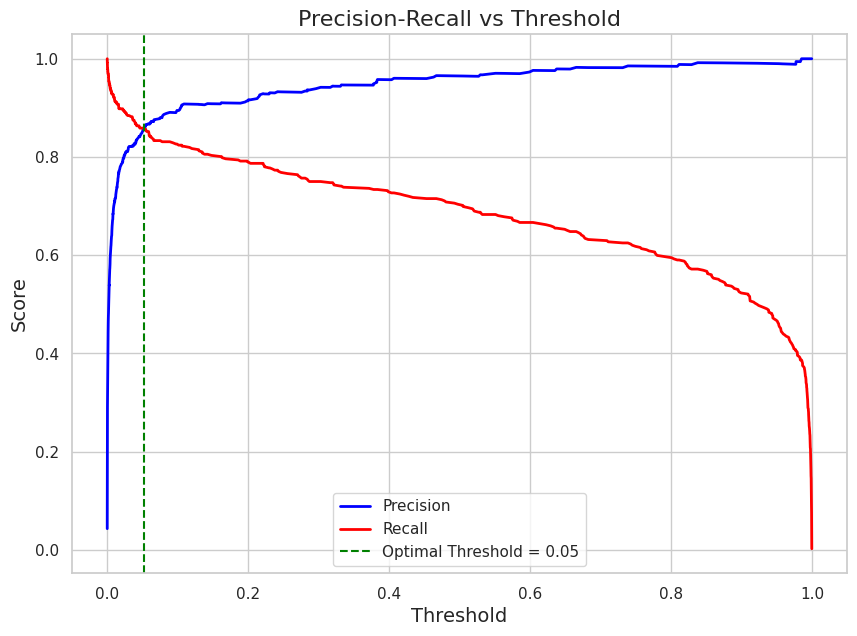

In [843]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y, results_full['predicted_proba'])

# Find intersection point of precision and recall
intersection = np.argmin(np.abs(precision[:-1] - recall[:-1]))
optimal_threshold = thresholds[intersection]


plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', color='red', linewidth=2)
plt.axvline(x=optimal_threshold, linestyle='--', color='green', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Precision-Recall vs Threshold', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix (Threshold = 0.05):


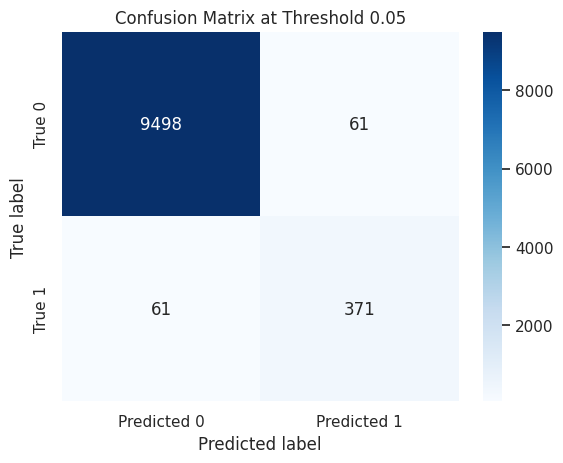

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9559
           1       0.86      0.86      0.86       432

    accuracy                           0.99      9991
   macro avg       0.93      0.93      0.93      9991
weighted avg       0.99      0.99      0.99      9991



In [848]:
# Show confusion matrix and metrics at selected threshold
def evaluate_threshold(threshold, y_true, y_proba):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"\nConfusion Matrix (Threshold = {threshold:.2f}):")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix at Threshold {threshold:.2f}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(report)

# Evaluate at optimal threshold
evaluate_threshold(optimal_threshold, y, results_full['predicted_proba'])


In [850]:
# FP and FN analysis by indicators
fp_fn_df = results_full.copy()
fp_fn_df['FP'] = ((fp_fn_df['Y'] == 0) & (fp_fn_df['predicted_proba'] >= optimal_threshold))
fp_fn_df['FN'] = ((fp_fn_df['Y'] == 1) & (fp_fn_df['predicted_proba'] < optimal_threshold))

fp_data = fp_fn_df[fp_fn_df['FP']]
fn_data = fp_fn_df[fp_fn_df['FN']]

print("Total FP:", fp_fn_df['FP'].sum())
print("Total FN:", fp_fn_df['FN'].sum())


Total FP: 61
Total FN: 61


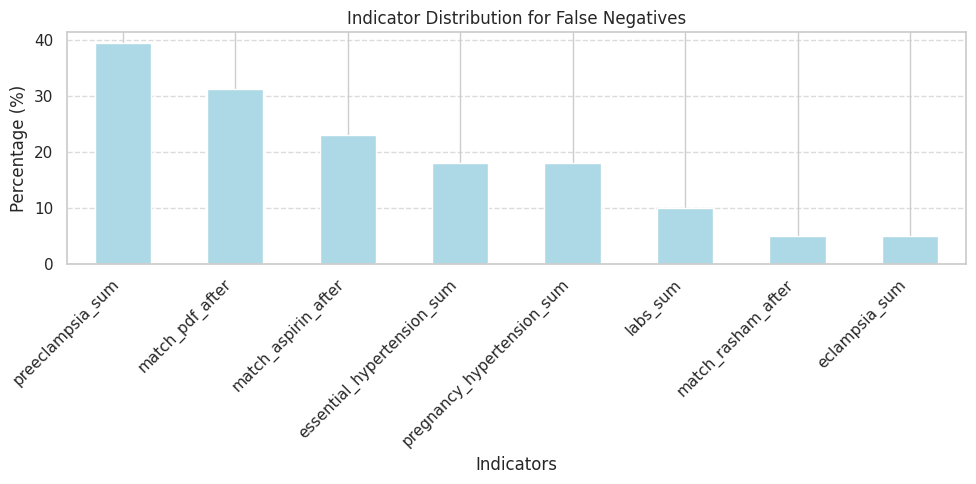

In [851]:


# Calculate percentage of indicators for FN
fn_indicator_means = fn_data[indicator_cols].mean().sort_values(ascending=False) * 100


# Plot for False Negatives
plt.figure(figsize=(10, 5))
fn_indicator_means.plot(kind='bar', color='lightblue')
plt.title('Indicator Distribution for False Negatives')
plt.ylabel('Percentage (%)')
plt.xlabel('Indicators')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

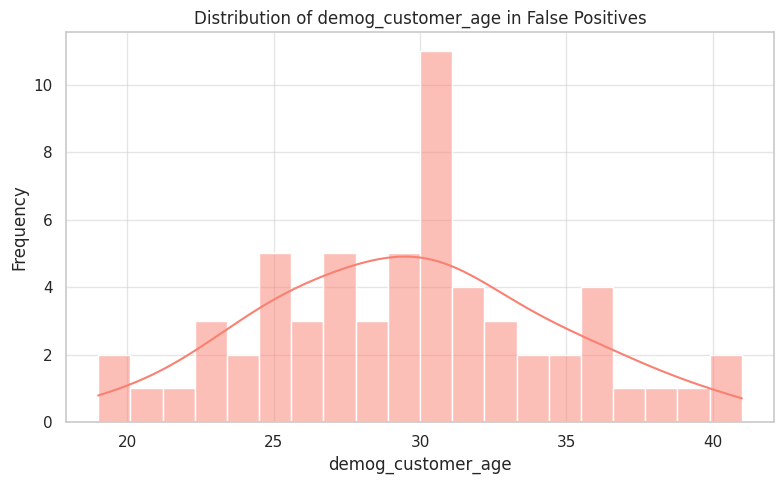

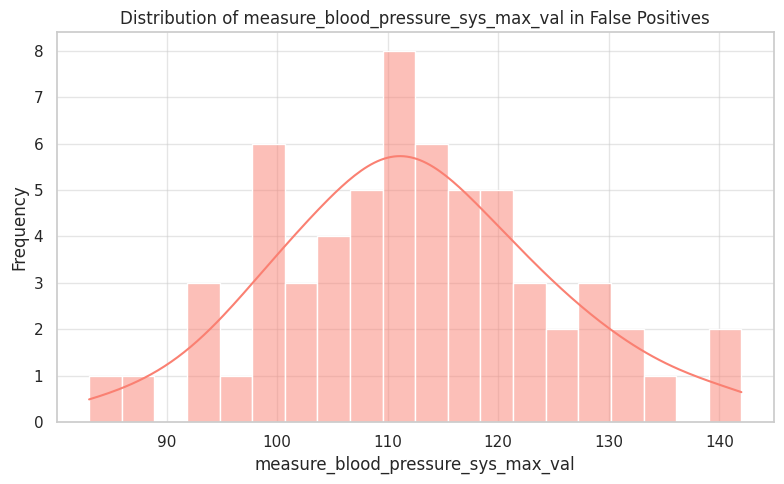

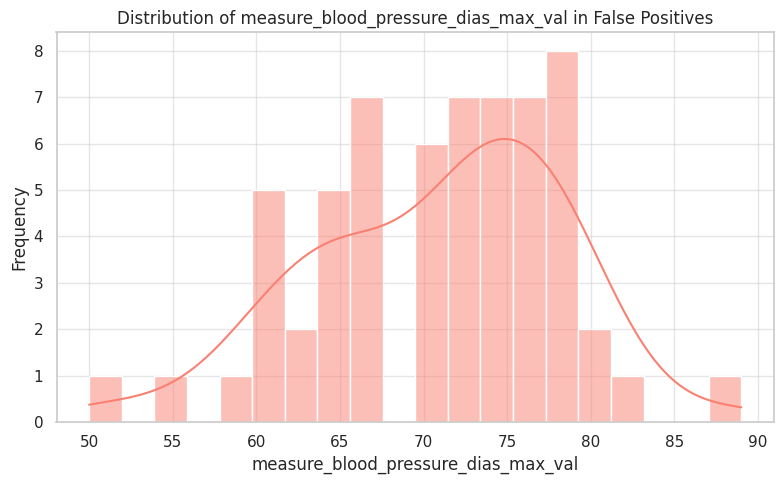

In [852]:

fp_analysis_cols = ['demog_customer_age', 'measure_blood_pressure_sys_max_val', 'measure_blood_pressure_dias_max_val']

fp_data = fp_fn_df[fp_fn_df['FP']]

# Plot FP distributions for relevant numeric columns
for col in fp_analysis_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(fp_data[col].dropna(), kde=True, color='salmon', bins=20)
    plt.title(f'Distribution of {col} in False Positives')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
results_full.sort_values(by='predicted_proba', ascending=False).head(10)

In [854]:
results_full.head(3).T

,0,1,2
demog_capitationcoefficient,0.73,0.79,0.79
demog_customer_age,33.0,34.0,35.0
smoking_is_smoker,0.0,1.0,2.0
smoking_smoking_years,0.0,1.86,8.92
smoking_total_heavy_smokers,0.0,0.0,0.0
...,...,...,...
word_ראייה,0,0,0
word_רעלת,0,0,0
word_שנים,0,0,0
last_week_paragraph,שבוע 15\n\nתלונות: תחושת חוסר נוחות באזור הבטן...,שבוע 15 להיריון\n\nתלונות: אין תלונות מיוחדות....,שבוע 15 להריון\n\nתלונות: המטופלת מתארת תחושת ...


# TODO

Elastic Net + Standard Scaler

יש הרבה פיצ'רים, עם המון קורלציות, גם בתוך קבוצות וגם ביניהן.


למצוא קורלציות גבוהות  ולהתמקד בהם יותר

TODO – השוואת ממצאים מהספרות לדאטה:

[ ] גבול לחץ דם גבוה בשבוע 10–13

[ ] חומצת שתן מוגברת (Uric Acid)

[ ] BMI גבוה

[ ] גיל אם מבוגר (demog_customer_age)

[ ] היסטוריה של GH/PE

[ ] היסטוריה משפחתית של GH/PE

[ ] היסטוריה של רעלת הריון

[ ] יתר לחץ דם כרוני

[ ] סוכרת טרום הריונית

[ ] מחלת כליה כרונית

[ ] מחלות אוטואימוניות (APS, SLE)

[ ] הריון מרובה עוברים (lab_num_of_fetuses_last_value – קבוע)

[ ] IVF או תרומת ביצית

[ ] פרימיפריות (הריון ראשון)

[ ] השמנת יתר (BMI ≥30)

[ ] היסטוריה משפחתית של רעלת

[ ] גיל אם מתקדם (>35) (demog_customer_age)

[ ] מרווח >10 שנים בין הריונות

[ ] מוצא אתני / סטטוס סוציו־אקונומי נמוך

[ ] MAP גבוה בשבוע 12

[ ] דופלר עורקי רחם פתולוגי (PI גבוה, Notch)

[ ] PAPP-A נמוך (lab_papp_a_MoM_last_value)

[ ] PlGF נמוך

[ ] sFlt-1 / sEng גבוהים

[ ] PP13 נמוך

[ ] יחס NLR גבוה

[ ] היסטוריה של אקלמפסיה

[ ] גיל אימהי צעיר (≤16) (demog_customer_age)

[ ] עישון בהריון (smoking_is_smoker)

[ ] אנמיה או תת־תזונה (Hemoglobin, RBC וכו')


להוסיף אגריגציה - לפחות 2 אגריציות

אינדיקטור אם היתה אבחנה בחצי שנה אחרונה


לפחות 3 פיצ'רים .

לתת חלוקה שווה לפי הרמות של בבדיקות וכו בחלוקה

1. ✅ Missing Impact Analysis
איך חוסרים בפיצ’ר משפיעים על Y?

האם נשים בלי בדיקה הן דווקא אלה עם אבחנה?
→ זה אינפורמטיבי!

2. ✅ Variance Filtering
משתנים עם שונות אפס או כמעט אפס → להסיר

תראי שעברת על זה אוטומטית, לא ידנית

3. ✅ Binary / Categorical Profiling
לכל עמודה קטגוריאלית — value counts

לא לחשוב ש־int = continuous

עמודות עם 2–5 ערכים = candidates ל־One Hot או Label Encoding

4. ✅ Feature Redundancy
heatmap בתוך תתי־קבוצות

או Clustering של פיצ’רים לפי קורלציה

5. ✅ Interaction Candidates
חיתוכים מעניינים:
preeclampsia_sum לפי גיל
lab_feature לפי מספר עוברים

זה בסיס ל־feature engineering מתקדם

6. ✅ Leakage Detection
כל משתנה עם corr(Y) > 0.9 – לבדוק אם לא זמינות עתידית

או משתנים עם value distribution שונה רק אחרי week 15



In [ ]:
df.describe()

In [ ]:
df.head(2).T

In [ ]:
df.isnull().sum().sort_values(ascending=False)

# Targets Correlations